c:\Users\punna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7863 - loss: 0.3999 - prc: 0.3805 - precision: 0.0090 - recall: 0.8384 - val_accuracy: 0.9426 - val_loss: 0.4668 - val_prc: 0.6896 - val_precision: 0.0277 - val_recall: 0.9490
Epoch 2/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9490 - loss: 0.3163 - prc: 0.5252 - precision: 0.0302 - recall: 0.8850 - val_accuracy: 0.7474 - val_loss: 0.6047 - val_prc: 0.6916 - val_precision: 0.0066 - val_recall: 0.9694
Epoch 3/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9425 - loss: 0.1942 - prc: 0.5374 - precision: 0.0274 - recall: 0.9354 - val_accuracy: 0.8567 - val_loss: 0.3998 - val_prc: 0.7152 - val_precision: 0.0115 - val_recall: 0.9694
Epoch 4/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9387 - loss: 0.1523 - prc: 0.6444 - precision: 0.0251 - recall: 0.9332 - val_accuracy: 0.9201 - val_loss: 0.2147 - val_prc: 0.6476 - val_precision: 0.0198 - val_recall: 0.9388
Epoch 5/35
112/112 ━━━━━━━━━

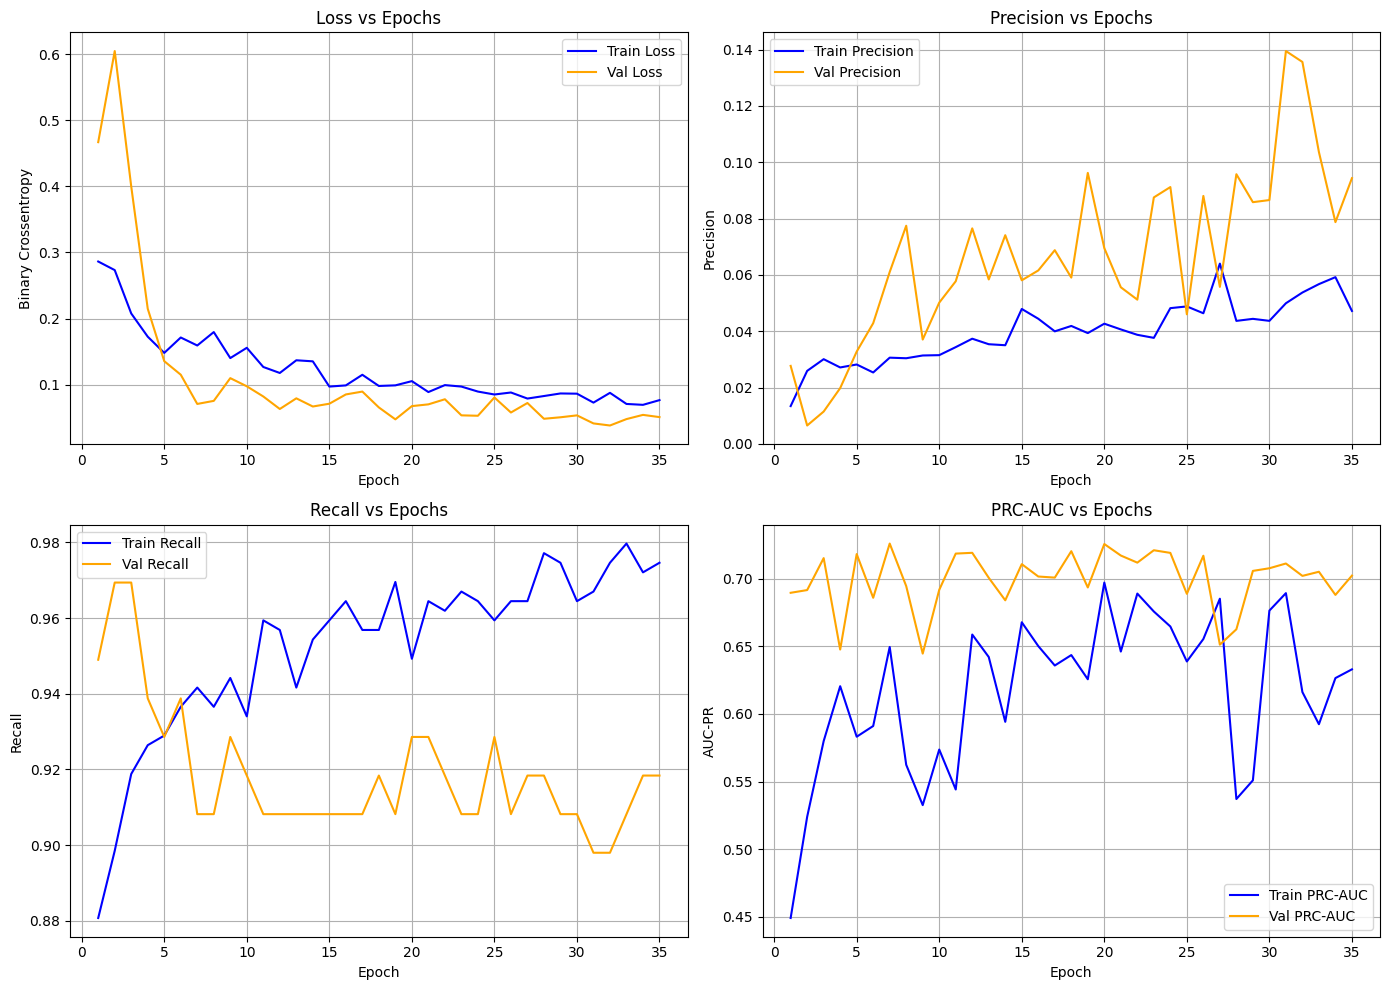

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load Dataset
df = pd.read_csv('creditcard.csv')

# 2. Split Features and Target
X = df.drop('Class', axis=1).values
y = df['Class'].values

# 3. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Reshape for Conv1D Layer
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# 7. Build Conv1D Model
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 8. Compile with extra metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(curve='PR', name='prc')])  # PRC: Precision-Recall AUC

# 9. Train the model (Limit to 35 epochs for plotting clarity)
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=2048,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    verbose=1
)

# 10. Plotting training and validation metrics
epochs = range(1, 36)  # 35 epochs

plt.figure(figsize=(14, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['precision'], label='Train Precision', color='blue')
plt.plot(epochs, history.history['val_precision'], label='Val Precision', color='orange')
plt.title('Precision vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, history.history['recall'], label='Train Recall', color='blue')
plt.plot(epochs, history.history['val_recall'], label='Val Recall', color='orange')
plt.title('Recall vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# PRC (Precision-Recall Curve AUC)
plt.subplot(2, 2, 4)
plt.plot(epochs, history.history['prc'], label='Train PRC-AUC', color='blue')
plt.plot(epochs, history.history['val_prc'], label='Val PRC-AUC', color='orange')
plt.title('PRC-AUC vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC-PR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
